# Rental Listing Price Model

Below are the steps taken to build our regression model which will be used to predict effective prices for prospective rental listings.

## Preparing the Data

First we need to clean and standardize the data scraped from the rental listing site in order to have the model train on it.

In [22]:
import sys
import os

# Assuming your desired directory is one level up from the notebook's directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

sys.path.append(current_dir)
sys.path.append(parent_dir)

from data.data_cleaner import get_cleaned_data
import pandas as pd
import numpy as np
import os

### Data Cleaning
`get_cleaned_data()` removes invalid and outlier data including blanks and data for single room listings. It also formats the building and unit amenities by making each column a dict that contains the relevant amenities as keys with a value of 1 if the listing has it, else 0.

`flatten_data()` flattens the building and unit amenities to put individual amenities into their own columns, essentially flattening the building and unit amenities dicts into separate columns in each row.

In [23]:
pd.set_option('display.max_columns', None)

df = pd.read_excel(f'{parent_dir}/data/rental_listings.xlsx')
df = get_cleaned_data(df)

print(len(df))

df.to_excel("cleaned_data.xlsx", index=False)

Index([   0,    0,    0,    0,    0,    1,    1,    1,    1,    1,
       ...
       4351, 4352, 4353, 4354, 4355, 4355, 4356, 4356, 4357, 4358],
      dtype='int64', length=11548)
3704


In [24]:
print("Printing columns:")
print(df.columns)

Printing columns:
Index(['Building', 'Address', 'Listing', 'Bed', 'Bath', 'SqFt', 'Price',
       'Pets', 'Latitude', 'Longitude', 'City', 'Controlled Access',
       'Fitness Center', 'Outdoor Space', 'Residents Lounge', 'Roof Deck',
       'Storage', 'Swimming Pool', 'Air Conditioning', 'Balcony', 'Furnished',
       'Hardwood Floor', 'High Ceilings', 'In Unit Laundry'],
      dtype='object')


In [25]:
print("Printing first 2 rows:")
print(df.head(2))

Printing first 2 rows:
             Building                                  Address    Listing  \
0  20 Samuel Wood Way  20 Samuel Wood Way, Toronto, ON M9B 0C8     Studio   
1  20 Samuel Wood Way  20 Samuel Wood Way, Toronto, ON M9B 0C8  1 Bedroom   

   Bed  Bath   SqFt  Price  Pets  Latitude  Longitude     City  \
0    0   1.0  370.0   2225     0  43.63526  -79.53992  Toronto   
1    1   1.0  540.0   2625     0  43.63526  -79.53992  Toronto   

   Controlled Access  Fitness Center  Outdoor Space  Residents Lounge  \
0                  1               1              1                 1   
1                  1               1              1                 1   

   Roof Deck  Storage  Swimming Pool  Air Conditioning  Balcony  Furnished  \
0          0        1              0                 0        0          0   
1          0        1              0                 0        0          0   

   Hardwood Floor  High Ceilings  In Unit Laundry  
0               0              0       

### The `Building` and `UnitType` class

For our purposes, we want to group the data by building type, unit type, and city as three major parameters. We created the `Building`, `UnitType`, `City` classes to group data together cleanly. This will become useful when dividing our data into a training and test set.

The `Building` class encompasses the relationship between a building name and the different types of units in it.

The `UnitType` class represents the different types of units where units are distinguished by number of bedrooms.

The `City` class contains all the `Building` values associated with a specific city.

In [26]:
from constants import TableHeaders
from classes import Building, City

In [27]:
cities: list[City] = []

print(df[TableHeaders.PRICE.value].value_counts())

# Filter out listings with prices greater than $5K - these extreme values are outliers
df = df[df[TableHeaders.PRICE.value] < 5000]

# Group data by city to extract city specific insights
city_groups = df.groupby(TableHeaders.CITY.value)

for city_name, city_df in city_groups:
    current_city = City(city_name)
    # Group city data by building name to extract building specific insights
    building_groups = city_df.groupby(TableHeaders.BUILDING.value)

    # Create an intermediary tuple to record number of available units and sort buildings accordingly
    # When displaying overarching insights for an area, buildings with more units will be more informational
    buildings_tuples = [(building, building_df, len(building_df)) for building, building_df in building_groups]
    buildings_tuples.sort(key = lambda x: x[2], reverse=True)

    for building_name, building_df, num_units in buildings_tuples:

        current_building: Building = Building(building_name, city_name)
        # Group by bed type within this building
        bed_groups = building_df.groupby(TableHeaders.BED.value)
        for unit_type, unit_type_df in bed_groups:
            current_building.add_unit_type(unit_type=unit_type, unit_type_df=unit_type_df)

        current_city.add_building(current_building) 

    cities.append(current_city)

    for building in current_city.buildings[:5]:
        print(building)

Price
1495    63
2240    33
1895    31
2500    25
2300    25
        ..
2357     1
1943     1
2759     1
2274     1
2956     1
Name: count, Length: 1460, dtype: int64
Building: Citizen on Jasper
Total Units: 75
Overall Average SqFt: 648.60
Overall Average Price: 2016.79
Overall Price Per SqFt: 3.11
-----------------------------------
Bedroom Type: 1 beds
 - Units: 61
 - Average SqFt: 585.95
 - Average Price: 1873.16
 - Price per SqFt: 3.20
-----------------------------------
Bedroom Type: 2 beds
 - Units: 13
 - Average SqFt: 905.77
 - Average Price: 2579.62
 - Price per SqFt: 2.85
-----------------------------------
Bedroom Type: 3 beds
 - Units: 1
 - Average SqFt: 1127.00
 - Average Price: 3461.00
 - Price per SqFt: 3.07
-----------------------------------

Building: Stadium Yards 
Total Units: 14
Overall Average SqFt: 743.71
Overall Average Price: 1717.14
Overall Price Per SqFt: 2.31
-----------------------------------
Bedroom Type: 0 beds
 - Units: 2
 - Average SqFt: 500.00
 - Avera

Since we want to partition the data into a test and train set with an even 20% split based on the unit type, let's remove the entries that have less than 5 listings for that unit type.

In [28]:
standardized_df = df.copy()
for city_name, city_df in city_groups:
    unit_groups = city_df.groupby(TableHeaders.BED.value)
    for unit_type, unit_df in unit_groups:
        # Filter out the unit listings that have less than 5 entries for that unit type
        # since it won't have sufficient data to split between testing and training
        if len(unit_df) < 5:
            # print(city_name, unit_type, len(unit_df))
            standardized_df = standardized_df.loc[
                ~((standardized_df[TableHeaders.CITY.value] == city_name) &
                (standardized_df[TableHeaders.BED.value] == unit_type))
            ]

In [29]:
for city in cities:
    print(f"City: {city.name}")
    for building in city.buildings[:5]:
        print(building)

City: Edmonton
Building: Citizen on Jasper
Total Units: 75
Overall Average SqFt: 648.60
Overall Average Price: 2016.79
Overall Price Per SqFt: 3.11
-----------------------------------
Bedroom Type: 1 beds
 - Units: 61
 - Average SqFt: 585.95
 - Average Price: 1873.16
 - Price per SqFt: 3.20
-----------------------------------
Bedroom Type: 2 beds
 - Units: 13
 - Average SqFt: 905.77
 - Average Price: 2579.62
 - Price per SqFt: 2.85
-----------------------------------
Bedroom Type: 3 beds
 - Units: 1
 - Average SqFt: 1127.00
 - Average Price: 3461.00
 - Price per SqFt: 3.07
-----------------------------------

Building: Stadium Yards 
Total Units: 14
Overall Average SqFt: 743.71
Overall Average Price: 1717.14
Overall Price Per SqFt: 2.31
-----------------------------------
Bedroom Type: 0 beds
 - Units: 2
 - Average SqFt: 500.00
 - Average Price: 1350.00
 - Price per SqFt: 2.70
-----------------------------------
Bedroom Type: 1 beds
 - Units: 4
 - Average SqFt: 603.00
 - Average Price:

## Training the Model

In [30]:
from sklearn.model_selection import train_test_split
city_groups = standardized_df.groupby(TableHeaders.CITY.value)
master_train_df = pd.DataFrame()
master_test_df = pd.DataFrame()
for city_name, city_df in city_groups:
    train_df, test_df = train_test_split(city_df, test_size=0.2, random_state=42, stratify=city_df[TableHeaders.BED.value])

    # Concatenate the individual city train and test sets with the master DataFrames
    master_train_df = pd.concat([master_train_df, train_df], ignore_index=True)
    master_test_df = pd.concat([master_test_df, test_df], ignore_index=True)

master_train_1_bed = len(master_train_df.loc[master_train_df[TableHeaders.BED.value] == 1])
master_test_1_bed = len(master_test_df.loc[master_test_df[TableHeaders.BED.value] == 1])
master_train_2_bed = len(master_train_df.loc[master_train_df[TableHeaders.BED.value] == 2])
master_test_2_bed = len(master_test_df.loc[master_test_df[TableHeaders.BED.value] == 2])

print(f"{(master_train_1_bed/master_train_2_bed):.2f}, {(master_test_1_bed/master_test_2_bed):.2f}")

1.36, 1.36


In [43]:
import torch
# Assuming 'target_column' is the name of your target variable
dropped_columns = [
    TableHeaders.PRICE.value,
    TableHeaders.BUILDING.value,
    TableHeaders.CITY.value,
    TableHeaders.LISTING.value,
    TableHeaders.ADDRESS.value,
    # TableHeaders.LAT.value,
    # TableHeaders.LON.value,
    # TableHeaders.PETS.value,
    # TableHeaders.SQFT.value,
    # TableHeaders.BED.value,
    # TableHeaders.BATH.value,
    # 'Balcony',
    # 'In Unit Laundry',
    # 'Air Conditioning',
    # 'High Ceilings',
    # 'Furnished',
    # 'Hardwood Floor',
    # 'Controlled Access',
    # 'Fitness Center',
    # 'Swimming Pool',
    # 'Roof Deck',
    # 'Storage',
    # 'Residents Lounge',
    # 'Outdoor Space',
]

# updated_df = master_train_df.loc[master_train_df[TableHeaders.CITY.value] == 'toronto']

updated_train_df = master_train_df.drop(dropped_columns, axis=1)
updated_test_df = master_test_df.drop(dropped_columns, axis=1)

X_train = torch.tensor(updated_train_df.values).float()
y_train = torch.tensor(master_train_df[TableHeaders.PRICE.value].values).float()

X_test = torch.tensor(updated_test_df.values).float()
y_test = torch.tensor(master_test_df[TableHeaders.PRICE.value].values).float()

# y_train = y_train.view(y_train.shape[0],1)
# y_test = y_test.view(y_test.shape[0],1)
for index, column in enumerate(updated_train_df.columns):
    print(column, X_train[0][index].item())

print("Unit Price: ", y_train[0].item())

tensor([   1.0000,    1.0000,  451.0000,    1.0000,   53.5510, -113.4975,
           1.0000,    0.0000,    0.0000,    0.0000,    0.0000,    1.0000,
           0.0000,    0.0000,    1.0000,    0.0000,    0.0000,    0.0000,
           0.0000])
Bed 1.0
Bath 1.0
SqFt 451.0
Pets 1.0
Latitude 53.55095672607422
Longitude -113.49750518798828
Controlled Access 1.0
Fitness Center 0.0
Outdoor Space 0.0
Residents Lounge 0.0
Roof Deck 0.0
Storage 1.0
Swimming Pool 0.0
Air Conditioning 0.0
Balcony 1.0
Furnished 0.0
Hardwood Floor 0.0
High Ceilings 0.0
In Unit Laundry 0.0
Unit Price:  1000.0


In [32]:
from dataset import RentalDataset
from torch.utils.data import DataLoader

train_dataset = RentalDataset(X_train, y_train)
test_dataset = RentalDataset(X_test, y_test)

batch_size = 32  # Choose a batch size that fits your model and training process

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

class RegressionModelV2(nn.Module):
    def __init__(self, input_size):
        super(RegressionModelV2, self).__init__()
        # Increasing the complexity of the model
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)  # Single output for regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # No activation function for the last layer in regression
        return x

input_size = X_train.shape[1]

# Replace input_size with the actual size of your input features
model = RegressionModelV2(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Learning rate can be adjusted

model.train()

for epoch in range(NUM_EPOCHS):
  for input, targets in train_loader:
    prediction = model(input)
    loss = criterion(prediction, targets)

    optimizer.zero_grad()  # Clear existing gradients
    loss.backward()  # Backpropagation
    optimizer.step()      # Update model parameters

  # Optional: Print the loss every epoch
  print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 1008303.6250


/Users/shivamjindal/Documents/Projects/Real Estate Scraper/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/shivamjindal/Documents/Projects/Real Estate Scraper/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Loss: 675124.7500
Epoch [3/50], Loss: 948355.6250
Epoch [4/50], Loss: 905555.1250
Epoch [5/50], Loss: 1233182.0000
Epoch [6/50], Loss: 1188497.8750
Epoch [7/50], Loss: 1203376.2500
Epoch [8/50], Loss: 1134438.6250
Epoch [9/50], Loss: 577753.0000
Epoch [10/50], Loss: 1332722.8750
Epoch [11/50], Loss: 829299.6875
Epoch [12/50], Loss: 716007.1875
Epoch [13/50], Loss: 921025.0000
Epoch [14/50], Loss: 839197.6250
Epoch [15/50], Loss: 507468.0625
Epoch [16/50], Loss: 951812.0000
Epoch [17/50], Loss: 529549.5000
Epoch [18/50], Loss: 1981480.6250
Epoch [19/50], Loss: 564910.4375
Epoch [20/50], Loss: 1509801.6250
Epoch [21/50], Loss: 422022.9375
Epoch [22/50], Loss: 579269.0625
Epoch [23/50], Loss: 985810.1250
Epoch [24/50], Loss: 747859.0000
Epoch [25/50], Loss: 689021.9375
Epoch [26/50], Loss: 835302.6875
Epoch [27/50], Loss: 1616510.2500
Epoch [28/50], Loss: 726627.0000
Epoch [29/50], Loss: 904815.2500
Epoch [30/50], Loss: 519196.6875
Epoch [31/50], Loss: 442031.0625
Epoch [32/

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Gradient computation is not needed for evaluation
  # Assuming you have tensors 'predictions' and 'actuals' for your test set
  predictions = model(X_test)  # X_test is your input tensor for the test set
  actuals = y_test  # y_test is the corresponding actual values tensor for the test set

  # Detach predictions and actuals from the computation graph if they require gradients
  predictions = predictions.detach()
  actuals = actuals.detach()

  # Convert to numpy arrays if needed
  predictions_np = predictions.numpy()
  actuals_np = actuals.numpy()

  # Calculate MSE and RMSE
  mse = mean_squared_error(actuals_np, predictions_np)
  rmse = sqrt(mse)

  # Calculate MAE
  mae = torch.mean(torch.abs(predictions - actuals)).item()

  # Calculate R-squared
  r2 = r2_score(actuals_np, predictions_np)

  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'R-squared: {r2}')
  # Code to evaluate the model on the test set

MAE: 717.0748901367188
MSE: 863309.5625
RMSE: 929.144532621271
R-squared: -0.16677786601558675


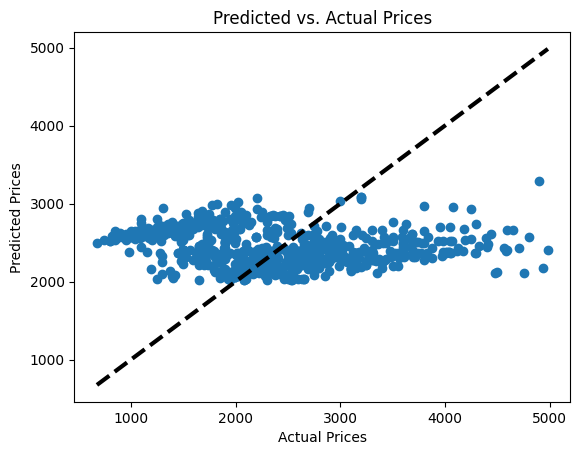

In [35]:
import matplotlib.pyplot as plt

# Assuming y_test is your actual values and predictions is your model's predictions
plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
plt.show()

In [36]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

regression_model.fit(X_train, y_train)

predictions = regression_model.predict(X_test)

print(f"{regression_model.score(X_test, y_test):.4f}")

0.7943


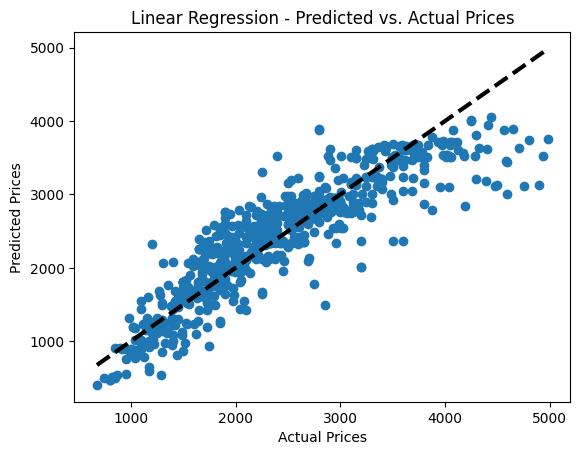

In [37]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression - Predicted vs. Actual Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
plt.show()

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Create the Random Forest classifier
random_forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
random_forest.fit(X_train, y_train)

# Predict using the test set
predictions = random_forest.predict(X_test)

# Evaluate accuracy
print(f"{random_forest.score(X_test, y_test):.4f}")

0.9162


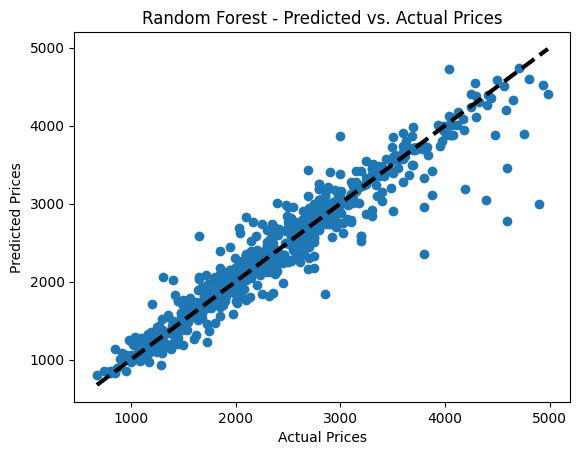

In [39]:
import matplotlib.pyplot as plt

# Assuming y_test is your actual values and predictions is your model's predictions
plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest - Predicted vs. Actual Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
plt.show()

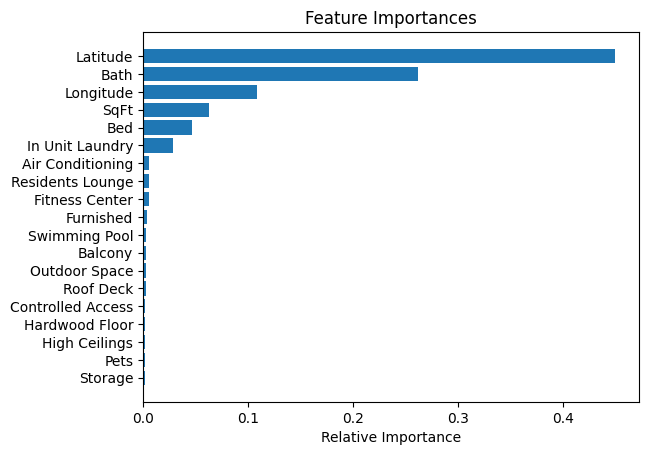

In [40]:
import numpy as np

# Assuming 'rf_model' is your trained Random Forest model and 'feature_names' is the list of feature names
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [updated_train_df.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [41]:
from joblib import dump

# Save random forest model
dump(random_forest, 'random_forest_model.joblib')

['random_forest_model.joblib']